### 사자와 치타 
- 미세 조정

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/lion/original/'

idg = ImageDataGenerator(rescale=1./255)

original_generator = idg.flow_from_directory(root, target_size=(64, 64), batch_size=32, class_mode='binary', shuffle=True)
print(original_generator.class_indices)

Found 200 images belonging to 2 classes.
{'Cheetahs': 0, 'Lions': 1}


In [2]:
target_name = {v: k for k, v in original_generator.class_indices.items()}
target_name

{0: 'Cheetahs', 1: 'Lions'}

In [3]:
original_target_names = []

for target in original_generator.classes:
    original_target_names.append(target_name[target])

print(original_target_names.__len__())

200


In [4]:
import pandas as pd

original_df = pd.DataFrame({'file_paths': original_generator.filepaths, 'target_names': original_target_names, 'targets': original_generator.classes})
original_df.file_paths = original_df.file_paths.apply(lambda file_path: file_path.replace('\\', '/'))


display(original_df)

,file_paths,target_names,targets
0,./datasets/lion/original/Cheetahs/0052cb267268...,Cheetahs,0
1,./datasets/lion/original/Cheetahs/00707659aba2...,Cheetahs,0
2,./datasets/lion/original/Cheetahs/007f9ffc01c7...,Cheetahs,0
3,./datasets/lion/original/Cheetahs/00bb45a8568a...,Cheetahs,0
4,./datasets/lion/original/Cheetahs/00c8d36882dd...,Cheetahs,0
...,...,...,...
195,./datasets/lion/original/Lions/e8c4adb3a073997...,Lions,1
196,./datasets/lion/original/Lions/eab5a653e7bc2c9...,Lions,1
197,./datasets/lion/original/Lions/eb226814a358576...,Lions,1
198,./datasets/lion/original/Lions/eb551b1c169fe18...,Lions,1


In [5]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(original_df.file_paths, 
                 original_df.targets, 
                 stratify=original_df.targets, 
                 test_size=0.2, random_state=124)

train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, train_targets, stratify=train_targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
1    64
0    64
Name: count, dtype: int64
targets
1    16
0    16
Name: count, dtype: int64
targets
0    20
1    20
Name: count, dtype: int64


In [15]:
import shutil
import os.path

base_dir = './datasets/lion/'


for filepath in train_images:
    destination = base_dir + 'train/' + filepath[len(base_dir + '/original'):filepath.rindex('/')]
    
    if not os.path.exists(destination):
        os.makedirs(destination)
    shutil.copy2(filepath, destination)

In [18]:
import shutil
import os.path

base_dir = './datasets/lion/'


for filepath in validation_images:
    destination = base_dir + 'validation/' + filepath[len(base_dir + '/original'):filepath.rindex('/')]
    
    if not os.path.exists(destination):
        os.makedirs(destination)
    shutil.copy2(filepath, destination)

In [19]:
import shutil
import os.path

base_dir = './datasets/lion/'


for filepath in test_images:
    destination = base_dir + 'test/' + filepath[len(base_dir + '/original'):filepath.rindex('/')]
    
    if not os.path.exists(destination):
        os.makedirs(destination)
    shutil.copy2(filepath, destination)

In [6]:
train_df = original_df.loc[train_images.index].reset_index(drop=True)
validation_df = original_df.loc[validation_images.index].reset_index(drop=True)
test_df = original_df.loc[test_images.index].reset_index(drop=True)

print(train_df.shape[0])
print(validation_df.shape[0])
print(test_df.shape[0])

128
32
40


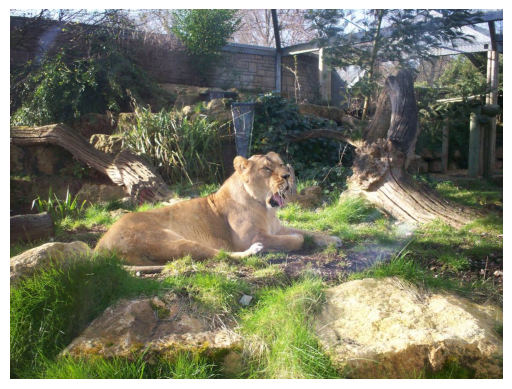

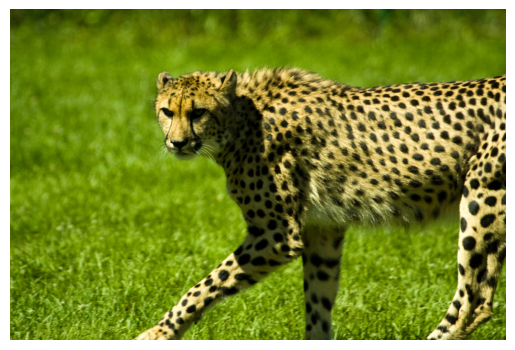

In [7]:
import cv2
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(train_df.file_paths.iloc[50]), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

image = cv2.cvtColor(cv2.imread(train_df.file_paths.iloc[100]), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
from tensorflow.keras.applications.resnet50 import preprocess_input

IMAGE_SIZE = 150
BATCH_SIZE = 64

train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_flow = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_paths',
    y_col='target_names',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    shuffle=True
)

validation_flow = validation_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_paths',
    y_col='target_names',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "binary"
)

test_flow = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_paths',
    y_col='target_names',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "binary"
)
print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 128 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
{'Cheetahs': 0, 'Lions': 1}
{'Cheetahs': 0, 'Lions': 1}
{'Cheetahs': 0, 'Lions': 1}


In [9]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 150
BATCH_SIZE = 64

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))

    # batch_size 단위로 이미지 배열과 타켓 데이터들을 가져온 뒤 변환한 값을 리턴한다.
    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            if self.preprocess is not None:
                image = self.preprocess(image)
                    
            results_batch[i] = image

        return results_batch, targets_batch
        
    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)        

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'efficientnet':
        model = EfficientNetB0(input_tensor=input_tensor, include_top=False, weights='imagenet')
        
    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(500, activation='relu', )(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [16]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

model = create_model(model_name='resnet50', verbose=True)
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['acc'])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 156, 156, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 75, 75, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 77, 77, 64)        │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 38, 38, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 38, 38, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 38, 38, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 38, 38, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 38, 38, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 38, 38, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 40, 40, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 38, 38, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 38, 38, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 38, 38, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 24,589,801 (93.80 MB)

 Trainable params: 24,544,361 (93.63 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from IPython.display import Audio

sound_file = './sounds/test.mp3'

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=8,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=8,
    mode='min'
)

In [17]:
import gc
gc.collect()

14

우선 훈련 진행

In [18]:
N_EPOCHS = 10

history = model.fit(train_flow,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_flow,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])
/

Epoch 1/10



KeyboardInterrupt



In [34]:
model.evaluate(test_flow)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - acc: 0.5000 - loss: 45.4338


[45.433807373046875, 0.5]

### Cycle 2
- Adam learning-rate를 1e-5으로 조정

In [20]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

model = create_model(model_name='resnet50', verbose=True)
model.compile(optimizer=Adam(1e-5), loss=BinaryCrossentropy(), metrics=['acc'])

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 156, 156, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 75, 75, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 77, 77, 64)        │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 38, 38, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 38, 38, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 38, 38, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 38, 38, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 38, 38, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 38, 38, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 40, 40, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 38, 38, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 38, 38, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 38, 38, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 24,589,801 (93.80 MB)

 Trainable params: 24,544,361 (93.63 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from IPython.display import Audio

sound_file = './sounds/test.mp3'

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=8,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=8,
    mode='min'
)

In [13]:
import gc
gc.collect()

14

In [22]:
N_EPOCHS = 10

history = model.fit(train_flow,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_flow,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 99s 11s/step - acc: 0.5365 - loss: 1.1034 - val_acc: 0.4688 - val_loss: 1.9441 - learning_rate: 1.0000e-05
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - acc: 0.5000 - loss: 1.0569 - val_acc: 0.5312 - val_loss: 1.3007 - learning_rate: 1.0000e-05
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 5s/step - acc: 0.4219 - loss: 1.0604 - val_acc: 0.5938 - val_loss: 1.0589 - learning_rate: 1.0000e-05
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - acc: 0.5260 - loss: 0.9198 - val_acc: 0.5000 - val_loss: 0.9431 - learning_rate: 1.0000e-05
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - acc: 0.6510 - loss: 0.7355 - val_acc: 0.5625 - val_loss: 0.8972 - learning_rate: 1.0000e-05
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - acc: 0.6042 - loss: 0.7821 - val_acc: 0.5625 - val_loss: 0.8812 - learning_rate: 1.0000e-05
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - acc: 0.7240 - loss: 0.5487 - val_acc: 0.5000 - val_loss: 0.8744 - learning_rate: 1.0000e-05
Epoch 8

In [23]:
model.evaluate(test_flow)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - acc: 0.5250 - loss: 0.7888


[0.7887528538703918, 0.5249999761581421]

### Cycle 3
- epoch를 30으로 늘려서 훈련 진행

In [24]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

model = create_model(model_name='resnet50', verbose=True)
model.compile(optimizer=Adam(1e-5), loss=BinaryCrossentropy(), metrics=['acc'])

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 156, 156, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 75, 75, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 77, 77, 64)        │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 38, 38, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 38, 38, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 38, 38, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 38, 38, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 38, 38, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 38, 38, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 40, 40, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 38, 38, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 38, 38, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 38, 38, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 24,589,801 (93.80 MB)

 Trainable params: 24,544,361 (93.63 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [26]:
import gc
gc.collect()

0

In [27]:
N_EPOCHS = 30

history = model.fit(train_flow,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_flow,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.4948 - loss: 0.8906 - val_acc: 0.5625 - val_loss: 1.6904 - learning_rate: 1.0000e-05
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - acc: 0.5573 - loss: 0.7883 - val_acc: 0.5938 - val_loss: 1.1514 - learning_rate: 1.0000e-05
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - acc: 0.5312 - loss: 0.8427 - val_acc: 0.5625 - val_loss: 1.0753 - learning_rate: 1.0000e-05
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - acc: 0.6302 - loss: 0.7810 - val_acc: 0.5625 - val_loss: 0.9391 - learning_rate: 1.0000e-05
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - acc: 0.6094 - loss: 0.6922 - val_acc: 0.6250 - val_loss: 0.7817 - learning_rate: 1.0000e-05
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - acc: 0.6719 - loss: 0.6252 - val_acc: 0.6250 - val_loss: 0.7393 - learning_rate: 1.0000e-05
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - acc: 0.7135 - loss: 0.5676 - val_acc: 0.5625 - val_loss: 0.7536 - learning_rate: 1.0000e-05
Epoch 8/30
2